sc22rb

Your full name:

Ritik Vinodkumar Bochiwal

### Imports

Feel free to add to this section as needed.

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

Detect which device (CPU/GPU) to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("/content/drive/MyDrive/Msc_Project/mscproject.csv")

imagesUnique = sorted(imageList['open_filename'].unique())
print(len(imagesUnique))

result_files =  pd.DataFrame.from_dict(imagesUnique)
df_id = list(sorted(imageList['id'].unique()))
result_files['id'] = df_id

df_unique_files =  pd.DataFrame.from_dict(imageList)
df_unique_files.columns = ['adj_filename','str_filename','open_filename','id']
df_unique_files['id'] = df_id
df_unique_files

1000


,adj_filename,str_filename,open_filename,id
0,adj_matrix_0.png,str_elem_0.png,opening_matrix_0.png,0
1,adj_matrix_1.png,str_elem_1.png,opening_matrix_1.png,1
2,adj_matrix_2.png,str_elem_2.png,opening_matrix_2.png,2
3,adj_matrix_3.png,str_elem_3.png,opening_matrix_3.png,3
4,adj_matrix_4.png,str_elem_4.png,opening_matrix_4.png,4
...,...,...,...,...
995,adj_matrix_995.png,str_elem_995.png,opening_matrix_995.png,995
996,adj_matrix_996.png,str_elem_996.png,opening_matrix_996.png,996
997,adj_matrix_997.png,str_elem_997.png,opening_matrix_997.png,997
998,adj_matrix_998.png,str_elem_998.png,opening_matrix_998.png,998


In [ ]:
result_files

,0,id
0,opening_matrix_0.png,0
1,opening_matrix_1.png,1
2,opening_matrix_10.png,2
3,opening_matrix_100.png,3
4,opening_matrix_101.png,4
...,...,...
995,opening_matrix_995.png,995
996,opening_matrix_996.png,996
997,opening_matrix_997.png,997
998,opening_matrix_998.png,998


This value represents the mean of the pixel values in the red color channel across all images in your dataset. A higher mean value indicates that, on average, the red color channel tends to have brighter pixel values.

This value represents the standard deviation of the pixel values in the red color channel across all images in your dataset. It measures the spread or variability of the pixel values in the red channel. A higher standard deviation indicates that the pixel values in the red channel are more spread out from the mean

In [ ]:
# Define the transformations for adjacency matrix image
adj_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.9676, 0.9251, 0.9251], std=[0.1210, 0.2294, 0.2294])
])

# Define the transformations for structuring element image
str_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.9917, 0.9806, 0.9806], std=[0.0630, 0.1215, 0.1215])
])

# Define the transformations for target opening image
target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.9593, 0.9334, 0.9334], std=[0.1348, 0.2034, 0.2034])
])

In [ ]:
from PIL import Image

def add_margins(image, left, upper, right, lower, fill_color=(255, 255, 255)):
    width, height = image.size
    new_width = width + left + right
    new_height = height + upper + lower
    new_image = Image.new("RGB", (new_width, new_height), fill_color)
    new_image.paste(image, (left, upper))
    return new_image

In [ ]:
#This is just for adj_matrix images
from natsort import natsorted
from PIL import Image

IMAGE_DIR_adj = "/content/drive/MyDrive/Msc_Project/adjacency_matrix"

class AdjDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        adj_filename = self.df.iloc[index]['adj_filename']
        id = self.df.iloc[index]['id']
        adj_img_loc = os.path.join(IMAGE_DIR_adj, adj_filename)

        # Use PIL for image loading
        adj_image = Image.open(adj_img_loc).convert("RGB")
        # Apply the transformations
        adj_image = self.transform(adj_image)

        return adj_image, id

    def __len__(self):
        return len(self.df)

In [ ]:
#This is just for str_elem images
from natsort import natsorted
from PIL import Image

IMAGE_DIR_str = "/content/drive/MyDrive/Msc_Project/structuring_elem"

class StrDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        str_filename = self.df.iloc[index]['str_filename']
        id = self.df.iloc[index]['id']
        str_img_loc = os.path.join(IMAGE_DIR_str, str_filename)

        # Use PIL for image loading
        str_image = Image.open(str_img_loc).convert("RGB")
        left_margin = 600
        upper_margin = 600
        right_margin = 600
        lower_margin = 600

        # Add the margins from each image
        str_image_padded = add_margins(str_image, left_margin, upper_margin, right_margin, lower_margin)

        # Apply the transformations
        str_image = self.transform(str_image)

        return str_image, id

    def __len__(self):
        return len(self.df)

In [ ]:
#This is just for target images
from natsort import natsorted
from PIL import Image

IMAGE_DIR_target = "/content/drive/MyDrive/Msc_Project/opening_result"

class TargetDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        open_filename = self.df.iloc[index]['open_filename']
        id = self.df.iloc[index]['id']
        open_img_loc = os.path.join(IMAGE_DIR_target, open_filename)

        # Use PIL for image loading
        open_image = Image.open(open_img_loc).convert("RGB")
        # Apply the transformations
        target_image = self.transform(open_image)

        return target_image, id

    def __len__(self):
        return len(self.df)

Update both the values in the transformation step at the top

In [ ]:
from natsort import natsorted
from PIL import Image
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms

IMAGE_DIR_adj = "/content/drive/MyDrive/Msc_Project/adjacency_matrix"
IMAGE_DIR_str = "/content/drive/MyDrive/Msc_Project/structuring_elem"
IMAGE_DIR_target = "/content/drive/MyDrive/Msc_Project/opening_result"

class CombinedDataset(Dataset):
    def __init__(self, df, transform_adj, transform_str, transform_target):
        self.df = df
        self.transform_adj = transform_adj
        self.transform_str = transform_str
        self.transform_target = transform_target

    def __getitem__(self, index):
        adj_filename = self.df.iloc[index]['adj_filename']
        str_filename = self.df.iloc[index]['str_filename']
        target_filename = self.df.iloc[index]['open_filename']
        id = self.df.iloc[index]['id']
        adj_img_loc = os.path.join(IMAGE_DIR_adj, adj_filename)
        str_img_loc = os.path.join(IMAGE_DIR_str, str_filename)
        target_img_loc = os.path.join(IMAGE_DIR_target,target_filename)

        # Use PIL for image loading
        adj_image = Image.open(adj_img_loc).convert("RGB")
        str_image = Image.open(str_img_loc).convert("RGB")
        target_image = Image.open(target_img_loc).convert("RGB")

        # Apply transformations
        adj_image = self.transform_adj(adj_image)
        str_image = self.transform_str(str_image)
        target_image = self.transform_target(target_image)

        # Combine the adjacency and structuring element images into a single tensor
        # combined_image = torch.cat((adj_image, str_image), dim=0)

        return adj_image, str_image, target_image

    def __len__(self):
        return len(self.df)

In [ ]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
# Use Dataloader to load the combined dataset
from torch.utils.data import DataLoader

adj_dataset = AdjDataset(df_unique_files, transform=adj_transform)
str_dataset = StrDataset(df_unique_files, transform=str_transform)
combined_dataset = CombinedDataset(df_unique_files,transform_adj=adj_transform, transform_str=str_transform, transform_target= target_transform)

adj_dataloader = DataLoader(
    adj_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

str_dataloader = DataLoader(
    str_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

combined_dataloader = DataLoader(
    combined_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# adj_data, adj_labels = next(iter(adj_dataloader))
# str_data, str_labels = next(iter(str_dataloader))
adj_data, str_data, target_data = next(iter(combined_dataloader))
print(adj_data.size())
print(str_data.size())
print(target_data.size())
# prints shape of image with single batch

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])


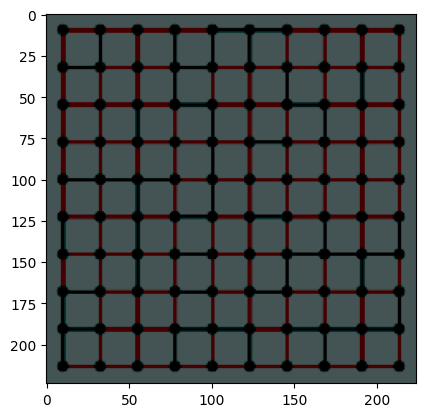

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63


In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()

# get some random training images using the data loader
dataiter = iter(adj_dataloader)
images, labels = next(dataiter)

# show images and labels
timshow(torchvision.utils.make_grid(images[0]))
print(*labels.numpy())

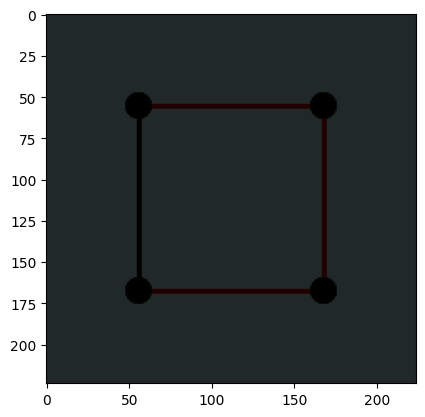

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63


In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()

# get some random training images using the data loader
dataiter = iter(str_dataloader)
images, labels = next(dataiter)

# show images and labels
timshow(torchvision.utils.make_grid(images[0]))
print(*labels.numpy())

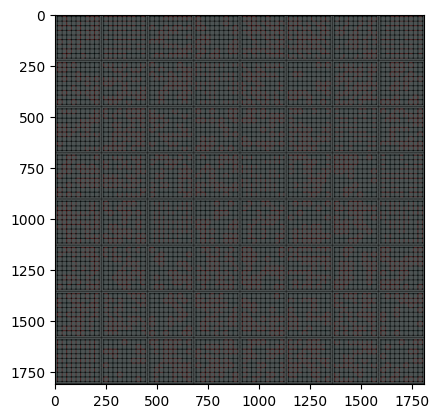

In [ ]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()

# get some random training images using the data loader
dataiter = iter(combined_dataloader)
_,_,images = next(dataiter)

# show images and labels
timshow(torchvision.utils.make_grid(images))

#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [ ]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)

    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [ ]:
img_id_list = df_unique_files['id'].unique()
train_ids,val_ids,test_ids = split_ids(img_id_list)
len(train_ids),len(val_ids),len(test_ids)

(700, 100, 200)

In [ ]:
train_val_ids = np.concatenate((train_ids,val_ids))
len(train_val_ids)

800

In [ ]:
train_df = df_unique_files[df_unique_files['id'].isin(train_ids)]
train_df

,adj_filename,str_filename,open_filename,id
0,adj_matrix_0.png,str_elem_0.png,opening_matrix_0.png,0
1,adj_matrix_1.png,str_elem_1.png,opening_matrix_1.png,1
3,adj_matrix_3.png,str_elem_3.png,opening_matrix_3.png,3
6,adj_matrix_6.png,str_elem_6.png,opening_matrix_6.png,6
7,adj_matrix_7.png,str_elem_7.png,opening_matrix_7.png,7
...,...,...,...,...
992,adj_matrix_992.png,str_elem_992.png,opening_matrix_992.png,992
993,adj_matrix_993.png,str_elem_993.png,opening_matrix_993.png,993
994,adj_matrix_994.png,str_elem_994.png,opening_matrix_994.png,994
995,adj_matrix_995.png,str_elem_995.png,opening_matrix_995.png,995


In [ ]:
val_df = df_unique_files[df_unique_files['id'].isin(val_ids)]
val_df

,adj_filename,str_filename,open_filename,id
2,adj_matrix_2.png,str_elem_2.png,opening_matrix_2.png,2
8,adj_matrix_8.png,str_elem_8.png,opening_matrix_8.png,8
13,adj_matrix_13.png,str_elem_13.png,opening_matrix_13.png,13
22,adj_matrix_22.png,str_elem_22.png,opening_matrix_22.png,22
23,adj_matrix_23.png,str_elem_23.png,opening_matrix_23.png,23
...,...,...,...,...
941,adj_matrix_941.png,str_elem_941.png,opening_matrix_941.png,941
954,adj_matrix_954.png,str_elem_954.png,opening_matrix_954.png,954
963,adj_matrix_963.png,str_elem_963.png,opening_matrix_963.png,963
996,adj_matrix_996.png,str_elem_996.png,opening_matrix_996.png,996


In [ ]:
test_df = df_unique_files[df_unique_files['id'].isin(test_ids)]
test_df

,adj_filename,str_filename,open_filename,id
4,adj_matrix_4.png,str_elem_4.png,opening_matrix_4.png,4
5,adj_matrix_5.png,str_elem_5.png,opening_matrix_5.png,5
10,adj_matrix_10.png,str_elem_10.png,opening_matrix_10.png,10
15,adj_matrix_15.png,str_elem_15.png,opening_matrix_15.png,15
20,adj_matrix_20.png,str_elem_20.png,opening_matrix_20.png,20
...,...,...,...,...
972,adj_matrix_972.png,str_elem_972.png,opening_matrix_972.png,972
977,adj_matrix_977.png,str_elem_977.png,opening_matrix_977.png,977
982,adj_matrix_982.png,str_elem_982.png,opening_matrix_982.png,982
985,adj_matrix_985.png,str_elem_985.png,opening_matrix_985.png,985


In [ ]:
train_val_df = df_unique_files[df_unique_files['id'].isin(train_val_ids)]
train_val_df

,adj_filename,str_filename,open_filename,id
0,adj_matrix_0.png,str_elem_0.png,opening_matrix_0.png,0
1,adj_matrix_1.png,str_elem_1.png,opening_matrix_1.png,1
2,adj_matrix_2.png,str_elem_2.png,opening_matrix_2.png,2
3,adj_matrix_3.png,str_elem_3.png,opening_matrix_3.png,3
6,adj_matrix_6.png,str_elem_6.png,opening_matrix_6.png,6
...,...,...,...,...
994,adj_matrix_994.png,str_elem_994.png,opening_matrix_994.png,994
995,adj_matrix_995.png,str_elem_995.png,opening_matrix_995.png,995
996,adj_matrix_996.png,str_elem_996.png,opening_matrix_996.png,996
998,adj_matrix_998.png,str_elem_998.png,opening_matrix_998.png,998


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = CombinedDataset(
    train_df,
    transform_adj=adj_transform,
    transform_str=str_transform,
    transform_target= target_transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=50,
    shuffle=True,
    num_workers=0
)

adj_data, str_data, target_data = next(iter(train_dataloader))
print(adj_data.size())
print(str_data.size())
print(target_data.size())

dataset_val = CombinedDataset(
    val_df,
    transform_adj=adj_transform,
    transform_str=str_transform,
    transform_target= target_transform
)

val_dataloader = DataLoader(
    dataset_val,
    batch_size=20,
    shuffle=False,
    num_workers=0
)

torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])
torch.Size([50, 3, 224, 224])


In [ ]:
# def timshow(x):
#     xa = np.transpose(x.numpy(),(1,2,0))
#     plt.imshow(xa)
#     plt.show()

# # get some random training images using the data loader
# dataiter = iter(train_dataloader)
# image1,image2,image3 = next(dataiter)

# # show images and labels
# timshow(torchvision.utils.make_grid(image2[0]))
# print(*labels.numpy())

## 3 Train Autoencoders

> 3.1 Traditional Autooencoders

> 3.2 Variational Autoencoders

#### 3.1 Traditional Autooencoders

We created two traditional autoencoders here. The first one was with basic architecture. the second one had a more complex architecture where we increased the number of kernels in the convolution layers, increased latent dimensions, changed sigmoid func to tanh func.

3.1.1 Basic Architecture

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, latent_dims, 7)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dims*2, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        z = torch.cat((z1, z2), dim=1)  # Concatenate the encoded features
        return self.decoder(z)

3.1.2 Complex architecture

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(),
            nn.Conv2d(64, latent_dims, 7)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dims*2, 64, 7),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        z = torch.cat((z1, z2), dim=1)  # Concatenate the encoded features
        return self.decoder(z)


second approach

In [ ]:
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 32, 5, stride=2, padding=2),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(),
            nn.Conv2d(64, latent_dims, 7)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dims, 64, 7),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x1, x2):
        # Concatenate the images along the channel dimension (dim=1)
        x = torch.cat((x1, x2), dim=1)

        # Encode the concatenated images
        z = self.encoder(x)

        # Pass the encoded features through the decoder
        return self.decoder(z)


Third Approach

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, latent_dims, 7)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dims*2, 128, 7),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        z = torch.cat((z1, z2), dim=1)
        return self.decoder(z)


In [ ]:
# Calculate Peak Signal-to-Noise Ratio (PSNR)
def calculate_psnr(original, reconstructed):
    mse = F.mse_loss(reconstructed, original)
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# Calculate Structural Similarity Index (SSIM)
def calculate_ssim(original, reconstructed):
    original_np = original.permute(0, 2, 3, 1).cpu().detach().numpy()
    reconstructed_np = reconstructed.permute(0, 2, 3, 1).cpu().detach().numpy()
    ssim_score = np.mean([ssim(original_np[i], reconstructed_np[i], channel_axis=2) for i in range(original_np.shape[0])])
    return ssim_score


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from skimage.metrics import structural_similarity as ssim

def train(model, device, train_dataloader, val_dataloader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.MSELoss() # Mean Square Error loss (L2-norm)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses = []
    val_losses = []
    train_psnrs = []
    train_ssims = []
    val_psnrs = []
    val_ssims = []
    outputs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_psnr_sum = 0.0
        train_ssim_sum = 0.0

        for data in train_dataloader:
            adj_img, str_img, target = data
            adj_img, str_img, target = adj_img.to(device), str_img.to(device), target.to(device)
            optimizer.zero_grad()
            recon = model(adj_img, str_img)
            loss = criterion(recon, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            target_inv = target_inv_transform(target)
            recon_inv = target_inv_transform(recon)

            # Calculate PSNR and SSIM for training accuracy
            psnr = calculate_psnr(target_inv, recon_inv)
            ssim = calculate_ssim(target_inv, recon_inv)
            train_psnr_sum += psnr
            train_ssim_sum += ssim

        # Calculate average PSNR and SSIM for training accuracy
        avg_train_psnr = train_psnr_sum / len(train_dataloader)
        avg_train_ssim = train_ssim_sum / len(train_dataloader)
        train_psnrs.append(avg_train_psnr)
        train_ssims.append(avg_train_ssim)

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_psnr_sum = 0.0
        val_ssim_sum = 0.0

        with torch.no_grad():
            for data in val_dataloader:
                adj_img, str_img, target = data
                adj_img, str_img, target = adj_img.to(device), str_img.to(device), target.to(device)
                recon = model(adj_img, str_img)
                loss = criterion(recon, target)
                val_loss += loss.item()
                target_inv = target_inv_transform(target)
                recon_inv = target_inv_transform(recon)

                # Calculate PSNR and SSIM for training accuracy
                psnr = calculate_psnr(target_inv, recon_inv)
                ssim = calculate_ssim(target_inv, recon_inv)
                val_psnr_sum += psnr
                val_ssim_sum += ssim

        # Calculate average PSNR and SSIM for training accuracy
        avg_val_psnr = val_psnr_sum / len(val_dataloader)
        avg_val_ssim = val_ssim_sum / len(val_dataloader)
        val_psnrs.append(avg_val_psnr)
        val_ssims.append(avg_val_ssim)

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train PSNR: {avg_train_psnr:.2f} dB, Train SSIM: {avg_train_ssim:.4f}, '
      f'Val Loss: {val_loss:.4f}, Val PSNR: {avg_val_psnr:.2f} dB, Val SSIM: {avg_val_ssim:.4f}')

        if(epoch%5 == 0):
          outputs.append((epoch, adj_img, str_img, recon),)

    # Save the model
    torch.save(model.state_dict(), '/content/drive/MyDrive/Msc_Project/Result/model_ap3_50_new.pth')

    # Save the outputs list
    torch.save(outputs, '/content/drive/MyDrive/Msc_Project/Result/outputs_ap3_50_new.pth')

    metrics = [train_losses,val_losses,train_psnrs,val_psnrs,train_ssims,val_ssims,epoch]

    torch.save(metrics, '/content/drive/MyDrive/Msc_Project/Result/metrics_ap3_50_new.pth')

In [ ]:
latent_dims = 256 # note we have 64-dim fixed inside the Autoencoder - try to change and see what happens
model = Autoencoder(latent_dims).to(device)
max_epochs = 50
train(model, device, train_dataloader, val_dataloader, num_epochs=max_epochs)

Epoch: 1/50, Train Loss: 0.5517, Train PSNR: 17.58 dB, Train SSIM: 0.4934, Val Loss: 0.4535, Val PSNR: 18.33 dB, Val SSIM: 0.6061
Epoch: 2/50, Train Loss: 0.3375, Train PSNR: 19.74 dB, Train SSIM: 0.6898, Val Loss: 0.3240, Val PSNR: 19.92 dB, Val SSIM: 0.7394
Epoch: 3/50, Train Loss: 0.2835, Train PSNR: 20.58 dB, Train SSIM: 0.7674, Val Loss: 0.2855, Val PSNR: 20.54 dB, Val SSIM: 0.7909
Epoch: 4/50, Train Loss: 0.2561, Train PSNR: 21.08 dB, Train SSIM: 0.8092, Val Loss: 0.2751, Val PSNR: 20.74 dB, Val SSIM: 0.8168
Epoch: 5/50, Train Loss: 0.2390, Train PSNR: 21.43 dB, Train SSIM: 0.8347, Val Loss: 0.2621, Val PSNR: 20.99 dB, Val SSIM: 0.8331
Epoch: 6/50, Train Loss: 0.2291, Train PSNR: 21.65 dB, Train SSIM: 0.8498, Val Loss: 0.2529, Val PSNR: 21.16 dB, Val SSIM: 0.8432
Epoch: 7/50, Train Loss: 0.2238, Train PSNR: 21.76 dB, Train SSIM: 0.8587, Val Loss: 0.2488, Val PSNR: 21.24 dB, Val SSIM: 0.8489
Epoch: 8/50, Train Loss: 0.2206, Train PSNR: 21.83 dB, Train SSIM: 0.8642, Val Loss: 0.247

Ap1 = 22.23, 0.8985 ; val ap1 = 21.92, 0.8836

Ap2 = 22.23, 0.8986 ; val ap2 = 22.21, 0.8984

Ap3 = 22.27, 0.9030; val ap3 = 22.07, 0.8934

In [ ]:
import matplotlib.pyplot as plt

def show_output(outputs, metrics):

  train_losses = metrics[0]
  val_losses = metrics[1]
  train_psnrs = metrics[2]
  val_psnrs = metrics[3]
  train_ssims = metrics[4]
  val_ssims = metrics[5]
  max_epochs = metrics[6]

  counter_list = list(range(0, output_tensor[-1][0] + 1,5))
  # Look at different epochs to see how reconstruction has worked
  for k in range(len(counter_list)):
      print(k)
      adj_img = outputs[k][1].to('cpu').detach()
      str_img = outputs[k][2].to('cpu').detach()
      recon = outputs[k][3].to('cpu').detach()

      for i, item in enumerate(adj_img[0]):
          if i >= 1: break
          timshow(torchvision.utils.make_grid(adj_img[0]))

      for i, item in enumerate(str_img[0]):
          if i >= 1: break
          timshow(torchvision.utils.make_grid(str_img[0]))

      for i, item in enumerate(recon[0]):
          if i >= 1: break
          timshow(torchvision.utils.make_grid(recon[0]))

  # Plot the graph
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 3, 1)
  plt.plot(range(0, max_epochs+1), train_losses, label='Train Loss')
  plt.plot(range(0, max_epochs+1), val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(range(0, max_epochs+1), train_psnrs, label='Train PSNR')
  plt.plot(range(0, max_epochs+1), val_psnrs, label='Val PSNR')
  plt.xlabel('Epoch')
  plt.ylabel('PSNR (db)')
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.plot(range(0, max_epochs+1), train_ssims, label='Train SSIM')
  plt.plot(range(0, max_epochs+1), val_ssims, label='Val SSIM')
  plt.xlabel('Epoch')
  plt.ylabel('SSIM')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
adj_inv_transform = transforms.Compose([ transforms.Normalize(mean = [-0.9676/0.1210, -0.9251/0.2294, -0.9251/0.2294],
                                                     std = [1/0.1210, 1/0.2294, 1/0.2294]),
                               ])

str_inv_transform = transforms.Compose([ transforms.Normalize(mean = [-0.9917/0.0630, -0.9806/0.1215, -0.9806/0.1215],
                                                     std = [1/0.0630, 1/0.1215, 1/0.1215]),
                               ])

target_inv_transform = transforms.Compose([ transforms.Normalize(mean = [-0.9593/0.1348, -0.9334/0.2034, -0.9334/0.2034],
                                                     std = [1/0.1348, 1/0.2034, 1/0.2034]),
                               ])

In [ ]:
import matplotlib.pyplot as plt

def show_output_2(outputs, metrics):

  train_losses = metrics[0]
  val_losses = metrics[1]
  train_psnrs = metrics[2]
  val_psnrs = metrics[3]
  train_ssims = metrics[4]
  val_ssims = metrics[5]
  max_epochs = metrics[6]

  counter_list = list(range(0, output_tensor[-1][0] + 1,5))
  # Look at different epochs to see how reconstruction has worked
  for k in range(len(counter_list)):
      print(k)
      adj_img = outputs[k][1].to('cpu').detach()
      str_img = outputs[k][2].to('cpu').detach()
      recon = outputs[k][3].to('cpu').detach()

      for i, item in enumerate(adj_img[0]):
          if i >= 1: break
          # enhance_brightness(adj_img[0])
          inv_adj_image = adj_inv_transform(adj_img[0])
          timshow(torchvision.utils.make_grid(inv_adj_image))
          # plt.subplot(3, 9, i + 1)
          # plt.imshow(item[0])

      for i, item in enumerate(str_img[0]):
          if i >= 1: break
          # enhance_brightness(str_img[0])
          inv_str_image = str_inv_transform(str_img[0])
          timshow(torchvision.utils.make_grid(inv_str_image))

      for i, item in enumerate(recon[0]):
          if i >= 1: break
          # enhance_brightness(recon[0])
          inv_target_image = target_inv_transform(recon[0])
          timshow(torchvision.utils.make_grid(inv_target_image))

  # Plot the graph
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 3, 1)
  plt.plot(range(0, max_epochs+1), train_losses, label='Train Loss')
  plt.plot(range(0, max_epochs+1), val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(range(0, max_epochs+1), train_psnrs, label='Train PSNR')
  plt.plot(range(0, max_epochs+1), val_psnrs, label='Val PSNR')
  plt.xlabel('Epoch')
  plt.ylabel('PSNR (db)')
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.plot(range(0, max_epochs+1), train_ssims, label='Train SSIM')
  plt.plot(range(0, max_epochs+1), val_ssims, label='Val SSIM')
  plt.xlabel('Epoch')
  plt.ylabel('SSIM')
  plt.legend()

  plt.tight_layout()
  plt.show()

# **Outputs**

1. Basic model

0


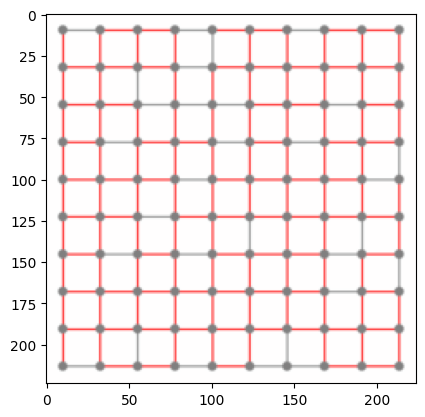

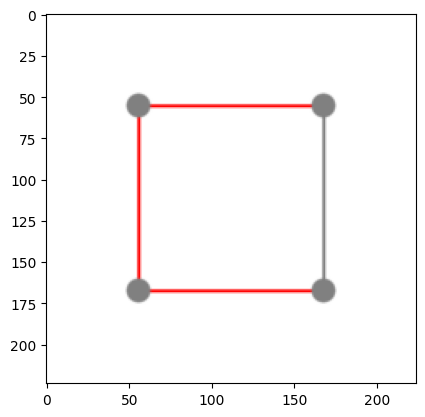

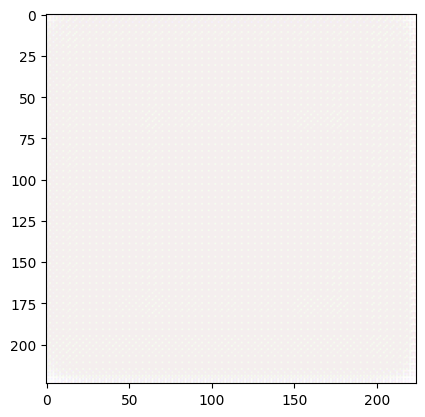

1


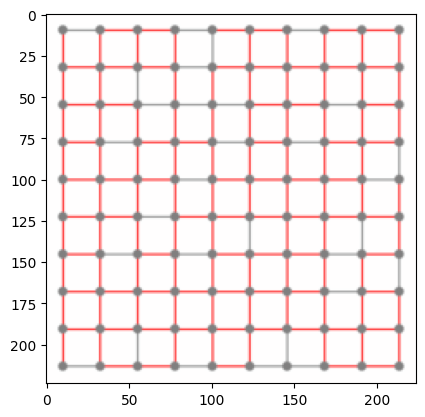

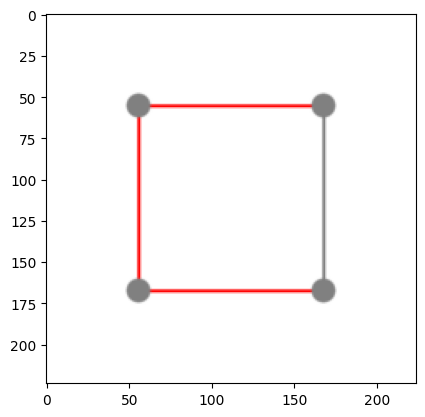

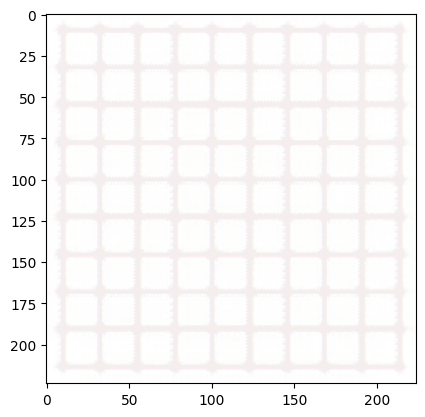

2


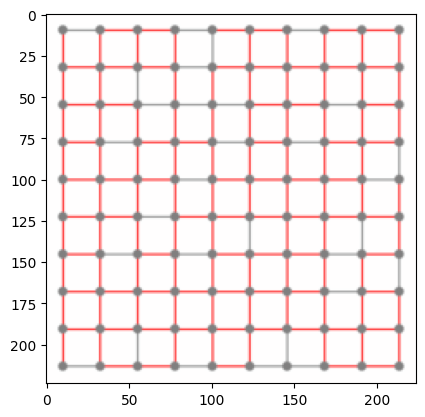

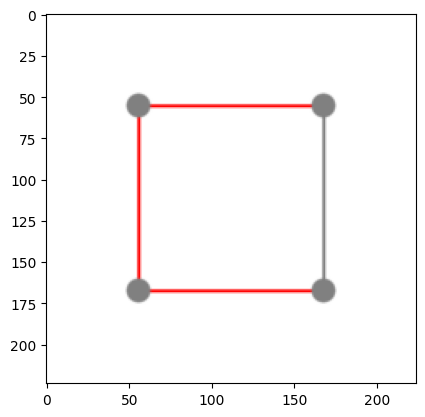

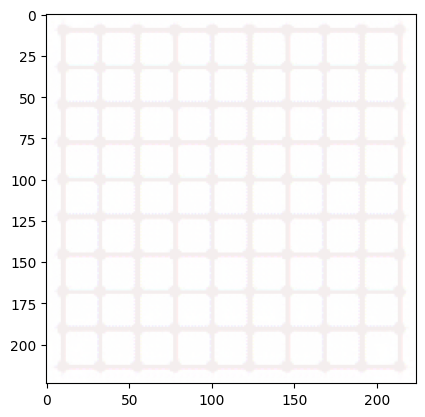

3


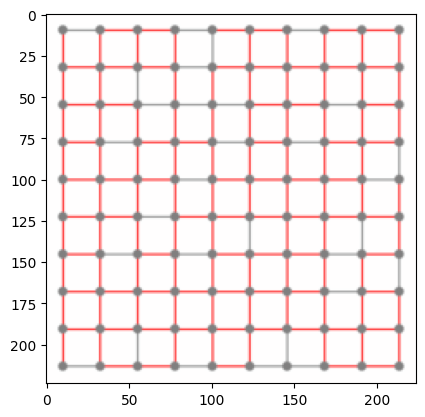

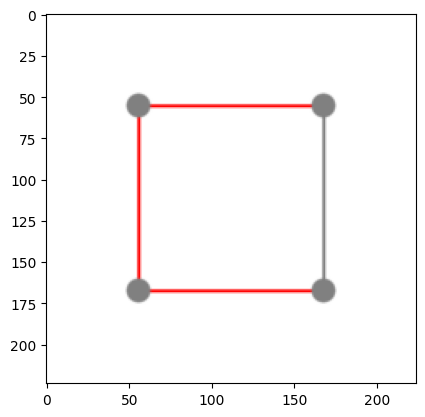

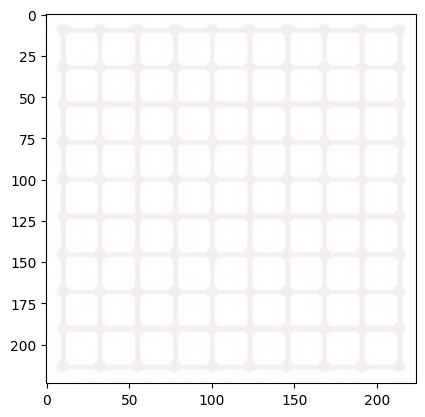

4


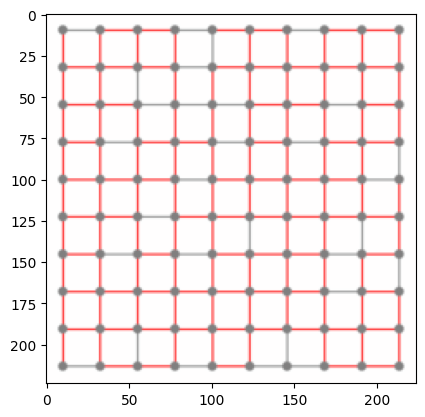

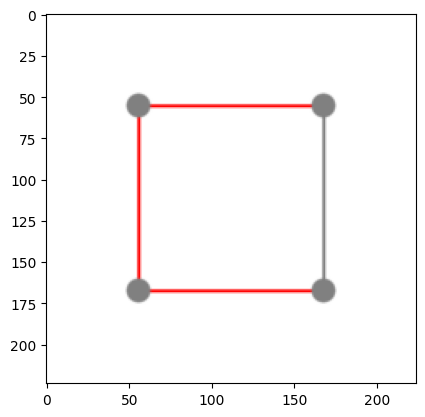

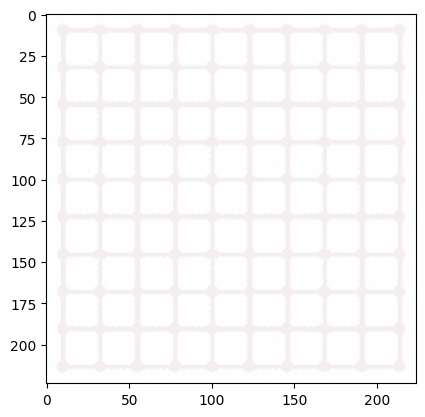

5


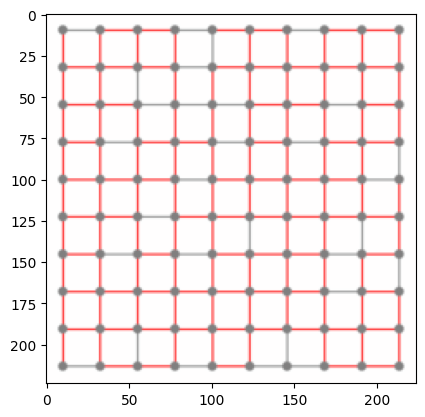

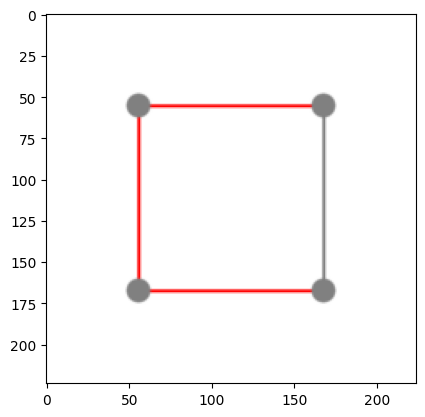

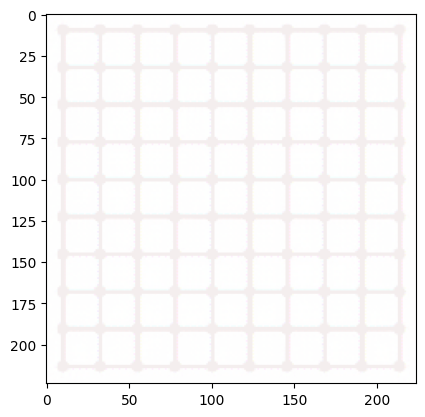

6


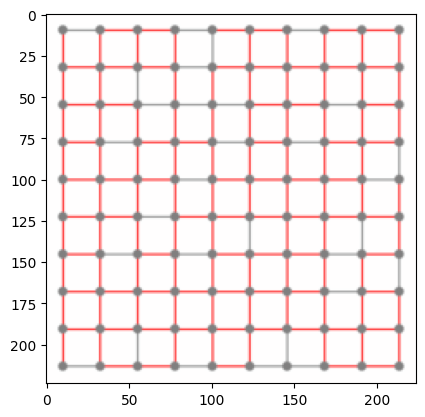

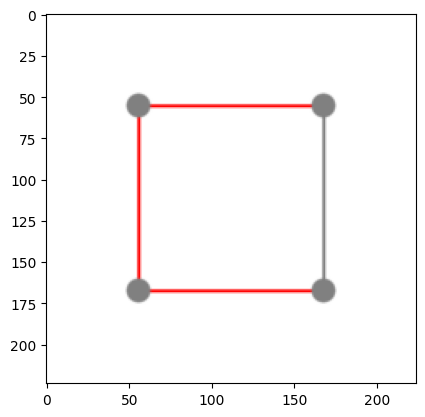

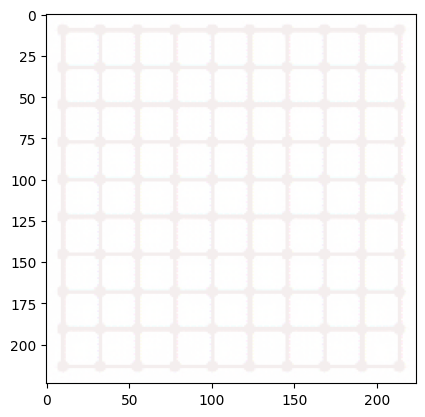

7


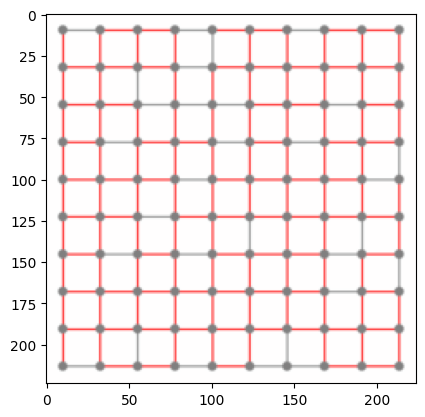

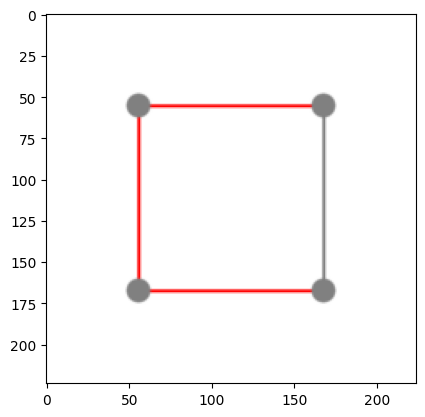

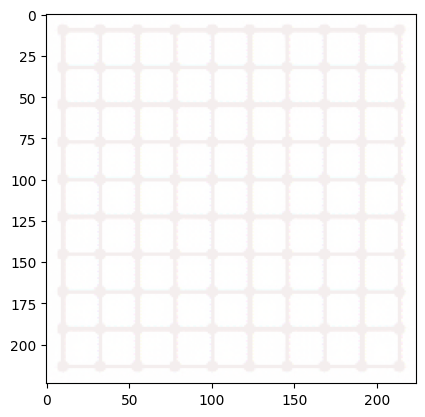

8


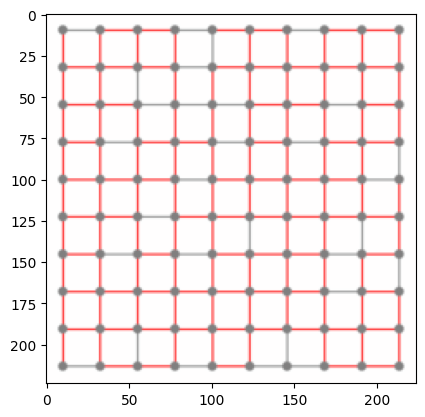

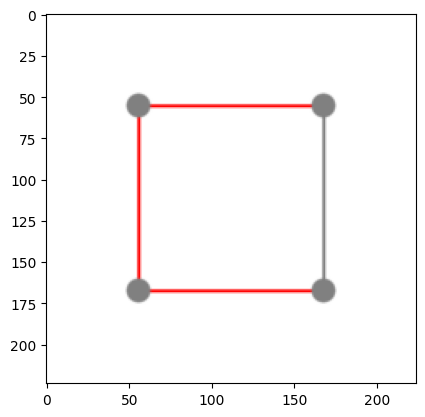

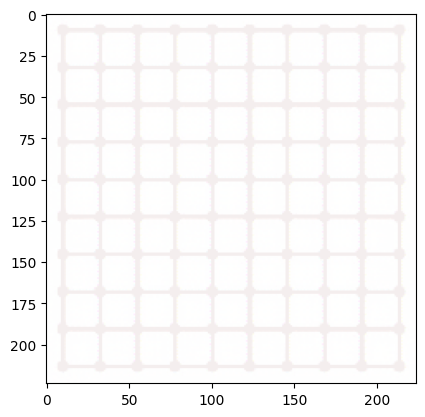

9


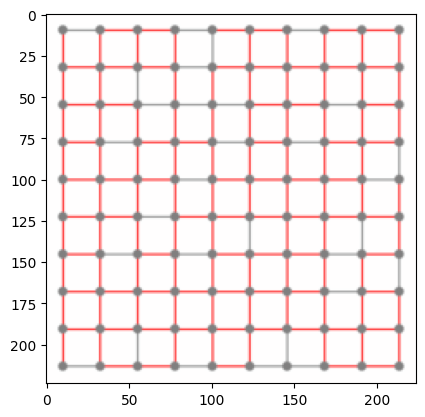

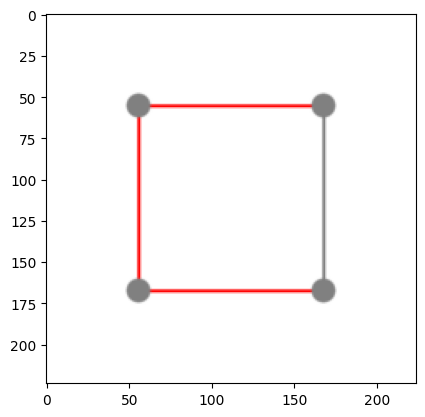

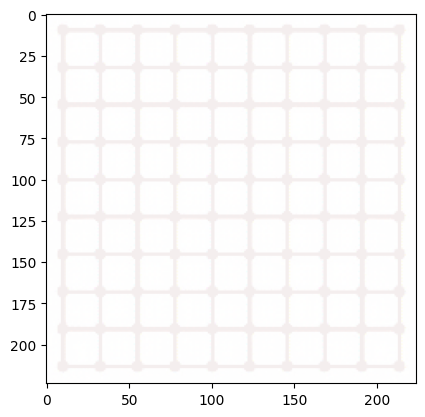

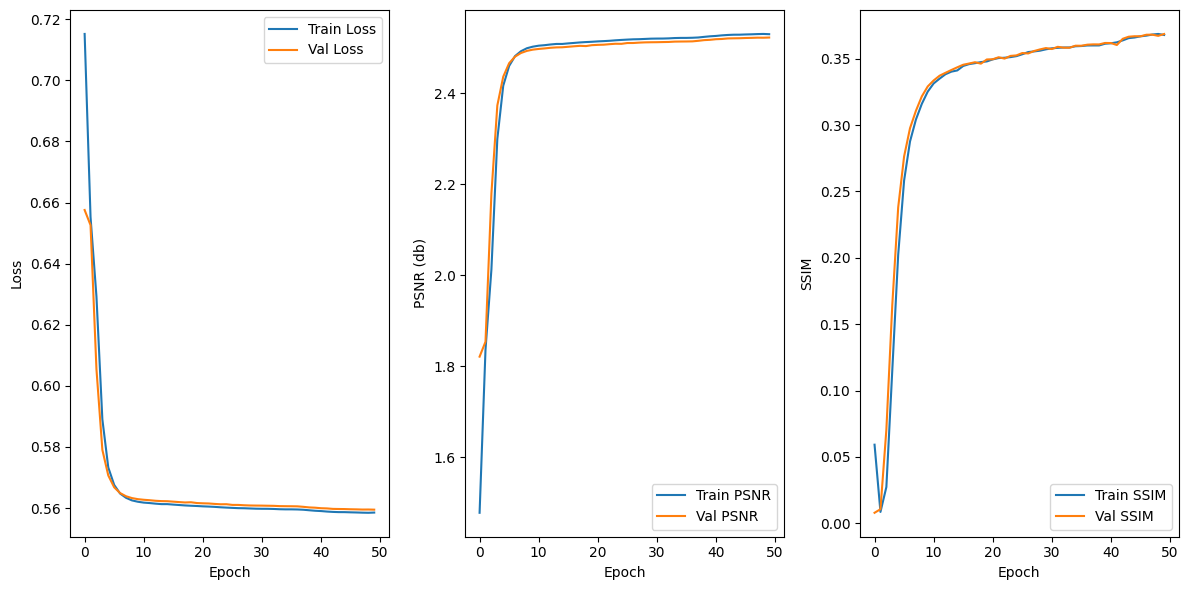

In [ ]:
#print output of basic model
output_tensor = torch.load('/content/drive/MyDrive/Msc_Project/Result/outputs_basic_50.pth')
metrics = torch.load('/content/drive/MyDrive/Msc_Project/Result/metrics_basic_50.pth')

show_output_2(outputs = output_tensor, metrics = metrics)

In [9]:
#print output of basic model
output_tensor = torch.load('/content/drive/MyDrive/Msc_Project/Result/outputs_ap1_50.pth')
metrics = torch.load('/content/drive/MyDrive/Msc_Project/Result/metrics_ap1_50.pth')

show_output_2(outputs = output_tensor, metrics = metrics)

#TEST

In [8]:
#print output of padded ap1 model
output_tensor = torch.load('/content/drive/MyDrive/Msc_Project/Result/outputs_ap1_50_new.pth')
metrics = torch.load('/content/drive/MyDrive/Msc_Project/Result/metrics_ap1_50_new.pth')

show_output(outputs = output_tensor, metrics = metrics)

In [7]:
#print output of padded ap1 model
output_tensor = torch.load('/content/drive/MyDrive/Msc_Project/Result/outputs_ap2_50_new.pth')
metrics = torch.load('/content/drive/MyDrive/Msc_Project/Result/metrics_ap2_50_new.pth')

show_output(outputs = output_tensor, metrics = metrics)

In [6]:
#print output of padded ap1 model
output_tensor = torch.load('/content/drive/MyDrive/Msc_Project/Result/outputs_ap3_50_new.pth')
metrics = torch.load('/content/drive/MyDrive/Msc_Project/Result/metrics_ap3_50_new.pth')

show_output(outputs = output_tensor, metrics = metrics)

In [ ]:
from google.colab.patches import cv2_imshow
import skimage.exposure
import cv2
def brightness(image):
  image = np.transpose(image.numpy(),(1,2,0))
  image = np.clip(image, 0, 1)  # Clip values to [0, 1] range
  image = (image * 255).astype(np.uint8)
  result = image.copy()

  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
  # cv2_imshow(hsv_image)
  # plt.imshow(hsv_image)
  # plt.show()
  # Define lower and upper bounds for red color in HSV
  lower_red = np.array([0, 50, 50])
  upper_red = np.array([20, 255, 255])

  # Define lower and upper bounds for black color in HSV
  lower_black = np.array([0, 0, 0])
  upper_black = np.array([180, 255, 30])

  # Create masks for red and black color pixels
  red_mask = cv2.inRange(hsv_image, lower_red, upper_red)
  black_mask = cv2.inRange(hsv_image, lower_black, upper_black)
  # cv2_imshow(red_mask)
  # cv2_imshow(black_mask)

  # Apply the masks to the original image to enhance the colors
  red_highlighted = cv2.bitwise_and(result, result, mask=red_mask)
  # black_highlighted = cv2.bitwise_and(image, image, mask=black_mask)
  # cv2_imshow(red_highlighted)

  # plt.imshow(red_highlighted)
  # plt.show()

  return red_highlighted

In [ ]:
def test(model, device, test_dataloader):
    model.eval()
    outputs = []

    with torch.no_grad():
        for data in test_dataloader:
            adj_img, str_img, target = data
            adj_img, str_img, target = adj_img.to(device), str_img.to(device), target.to(device)
            recon = model(adj_img, str_img)
            outputs.append((adj_img, str_img, recon, target))

    return outputs

In [ ]:
from torch.utils.data import DataLoader

# Now you can use DataLoader in your code
dataset_test = CombinedDataset(
    test_df,
    transform_adj=adj_transform,
    transform_str=str_transform,
    transform_target= target_transform
)

test_dataloader = DataLoader(
    dataset_test,
    batch_size=20,
    shuffle=False,
    num_workers=0
)

In [ ]:
print(len(test_dataloader))

10


In [ ]:
# def test_output(test_outputs):
#   counter_list = list(range(0, len(test_dataloader)))
#   # Look at different epochs to see how reconstruction has worked
#   for k in range(len(counter_list)):
#         print(k)
#         adj_img = test_outputs[k][0].to('cpu').detach()
#         str_img = test_outputs[k][1].to('cpu').detach()
#         recon = test_outputs[k][2].to('cpu').detach()
#         open = test_outputs[k][3].to('cpu').detach()

#         for i, item in enumerate(adj_img[0]):
#             if i >= 1: break
#             inv_adj_image = adj_inv_transform(adj_img[0])
#             timshow(torchvision.utils.make_grid(inv_adj_image))
#             brightness(torchvision.utils.make_grid(inv_adj_image))

#         for i, item in enumerate(str_img[0]):
#             if i >= 1: break
#             inv_str_image = str_inv_transform(str_img[0])
#             timshow(torchvision.utils.make_grid(inv_str_image))
#             brightness(torchvision.utils.make_grid(inv_str_image))

#         for i, item in enumerate(recon[0]):
#             if i >= 1: break
#             inv_target_image = target_inv_transform(recon[0])
#             timshow(torchvision.utils.make_grid(inv_target_image))
#             brightness(torchvision.utils.make_grid(inv_target_image))

#         for i, item in enumerate(open[0]):
#             if i >= 1: break
#             inv_open_image = target_inv_transform(open[0])
#             timshow(torchvision.utils.make_grid(inv_open_image))
#             brightness(torchvision.utils.make_grid(inv_open_image))

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
def test_output(test_outputs):
  counter_list = list(range(0, len(test_dataloader)))

  #to capture metrics
  test_psnr_sum = 0.0
  test_ssim_sum = 0.0
  for k in range(len(counter_list)):
        print(k)
        adj_img = test_outputs[k][0].to('cpu').detach()
        str_img = test_outputs[k][1].to('cpu').detach()
        recon = test_outputs[k][2].to('cpu').detach()
        open = test_outputs[k][3].to('cpu').detach()

        for i, item in enumerate(adj_img[0]):
            if i >= 1: break
            # enhance_brightness(adj_img[0])
            inv_adj_image = adj_inv_transform(adj_img[0])
            timshow(torchvision.utils.make_grid(inv_adj_image))
            hsv_adj = brightness(torchvision.utils.make_grid(inv_adj_image))
            # plt.subplot(3, 9, i + 1)
            # plt.imshow(item[0])

        for i, item in enumerate(str_img[0]):
            if i >= 1: break
            # enhance_brightness(str_img[0])
            inv_str_image = str_inv_transform(str_img[0])
            timshow(torchvision.utils.make_grid(inv_str_image))
            hsv_str = brightness(torchvision.utils.make_grid(inv_str_image))

        inv_recon = []
        for i in range(recon.shape[0]):
            # enhance_brightness(recon[0])
            inv_target_image = target_inv_transform(recon[i])
            # Pass only the first image to timshow_test
            if(i==0):
              timshow(torchvision.utils.make_grid(inv_target_image))
            hsv_recon = brightness(torchvision.utils.make_grid(inv_target_image))
            if(i==0):
              plt.imshow(hsv_recon)
              plt.show()
            inv_recon.append(inv_target_image)
        inv_recon = torch.stack(inv_recon, dim=0)

        inv_open = []
        for i in range(open.shape[0]):
            inv_open_image = target_inv_transform(open[i])
            # Pass only the first image to timshow_test
            if i == 0:
              timshow(torchvision.utils.make_grid(inv_open_image))
            hsv_open = brightness(torchvision.utils.make_grid(inv_open_image))
            if(i==0):
              plt.imshow(hsv_open)
              plt.show()
            inv_open.append(inv_open_image)
        inv_open = torch.stack(inv_open, dim=0)

        print(inv_open.shape, inv_recon.shape)
        print(open.shape,recon.shape)

        # Calculate PSNR and SSIM for test accuracy
        psnr = calculate_psnr(inv_open, inv_recon)
        ssim = calculate_ssim(inv_open, inv_recon)
        test_psnr_sum += psnr
        test_ssim_sum += ssim

  # Calculate average PSNR and SSIM for test accuracy
  avg_test_psnr = test_psnr_sum / len(test_dataloader)
  avg_test_ssim = test_ssim_sum / len(test_dataloader)

  print("Avg Test PSNR", avg_test_psnr)
  print("Avg Test SSIM", avg_test_ssim)

In [5]:
# model = Autoencoder(64)
# model.load_state_dict(torch.load('/content/drive/MyDrive/Msc_Project/Result/model_ap1_50.pth'))
# model = model.to(device)

# # Call the test function
# test_outputs = test(model, device, test_dataloader)
# test_output(test_outputs)

# # Save the test outputs
# torch.save(test_outputs, '/content/drive/MyDrive/Msc_Project/Result/test_ap1_50_2.pth')

test_outputs = torch.load('/content/drive/MyDrive/Msc_Project/Result/test_ap1_50_2.pth',map_location = torch.device('cpu'))
test_output(test_outputs)

In [4]:
model = Autoencoder(64)
# model.load_state_dict(torch.load('/content/drive/MyDrive/Msc_Project/Result/model_ap2_50.pth'))
# model = model.to(device)

# # Call the test function
# test_outputs = test(model, device, test_dataloader)
# test_output(test_outputs)

# # Save the test outputs
# torch.save(test_outputs, '/content/drive/MyDrive/Msc_Project/Result/test_ap2_50_2.pth')
test_outputs = torch.load('/content/drive/MyDrive/Msc_Project/Result/test_ap2_50_2.pth',map_location = torch.device('cpu'))
test_output(test_outputs)

In [3]:
model = Autoencoder(64)
model.load_state_dict(torch.load('/content/drive/MyDrive/Msc_Project/Result/model_padded_ap1_50.pth'))
model = model.to(device)

# Call the test function
test_outputs = test(model, device, test_dataloader)
test_output(test_outputs)

# Save the test outputs
torch.save(test_outputs, '/content/drive/MyDrive/Msc_Project/Result/test_padded_ap1_50.pth')
# test_outputs = torch.load('/content/drive/MyDrive/Msc_Project/Result/test_padded_ap1_50.pth',map_location = torch.device('cpu'))
# test_output(test_outputs)

In [2]:
model = Autoencoder(256)
model.load_state_dict(torch.load('/content/drive/MyDrive/Msc_Project/Result/model_ap3_50_new.pth'))
model = model.to(device)

# Call the test function
test_outputs = test(model, device, test_dataloader)
test_output(test_outputs)

# Save the test outputs
torch.save(test_outputs, '/content/drive/MyDrive/Msc_Project/Result/test_ap3_50_new.pth')
# test_outputs = torch.load('/content/drive/MyDrive/Msc_Project/Result/test_ap1_128_50.pth')
# test_output(test_outputs)

In [1]:
model = Autoencoder(128)
model.load_state_dict(torch.load('/content/drive/MyDrive/Msc_Project/Result/model_ap2_50_new.pth'))
model = model.to(device)

# Call the test function
test_outputs = test(model, device, test_dataloader)
test_output(test_outputs)

# Save the test outputs
torch.save(test_outputs, '/content/drive/MyDrive/Msc_Project/Result/test_ap2_50_new.pth')
# test_outputs = torch.load('/content/drive/MyDrive/Msc_Project/Result/test_ap1_128_50.pth')
# test_output(test_outputs)

#### 3.2 Variational Autoencoders

1st approach:

Concatenating Images before Encoding (Current Approach):

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, 5, stride=2, padding=2)  # Concatenate two images along the channel dimension
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.conv_mu = nn.Conv2d(64, latent_dims, 7)
        self.conv_var = nn.Conv2d(64, latent_dims, 7)
        self.training = True

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)  # Concatenate the two images along the channel dimension
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        mu = self.conv_mu(x)
        log_var = self.conv_var(x)

        if self.training:
            x = self.sample(mu, log_var)
        else:
            x = mu

        return x, mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dims, 64, 7),  # Use latent_dims as the number of channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()  # Try using Tanh as the final activation function
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x1, x2):
        z, mu, log_var = self.encoder(x1, x2)  # Pass both images to the encoder
        img_reconstruct = self.decoder(z)
        return img_reconstruct, mu, log_var

In [ ]:
# Define a KL-divegence loss
def kl_loss(mu, log_var):
  KLD      = - 0.5 * torch.sum(1+ log_var - mu.pow(2) - log_var.exp())
  return KLD

# Alternative to MSE, you can also use BCE (binary cross entropy)
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mu, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mu.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [ ]:
def train_VAE(model, device, num_epochs=5, learning_rate=1e-4, print_on=True):
    criterion = nn.MSELoss() # mean square error loss (l2-norm)
    beta = 1.0 # set a weight to balance between two losses
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_dataloader:
            adj_img, str_img, target = data
            recon, mu, log_var = model(adj_img.to(device), str_img.to(device))
            # loss1 = criterion(recon, img.to(device)) # MSE loss as before
            # loss2 = kl_loss(mu, log_var) # added KL-divergence loss
            # loss = loss1 + beta * loss2
            loss = loss_function(target.to(device), recon, mu, log_var)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if print_on:
          print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, adj_img, str_img, recon),)

    # Save the model
    torch.save(model.state_dict(), '/content/drive/MyDrive/Msc_Project/Result/vae_model_64_50.pth')

    # Save the outputs list
    torch.save(outputs, '/content/drive/MyDrive/Msc_Project/Result/vae_outputs_64_50.pth')

    return outputs, model

In [ ]:
latent_dims = 2
model_VAE = VariationalAutoencoder(latent_dims).to(device)
max_epochs = 50
outputs_VAE, model_VAE = train_VAE(model_VAE, device, num_epochs=max_epochs, print_on=True)

RuntimeError: ignored